In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

# for some conversion between thermodynamic variables
from metpy.units import units
from metpy.calc import thermo

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# data directoies
dir_era5 = Path('/neelin2020/ERA-5/NC_FILES/')
dir_buoy = Path('/neelin2020/ERA-5_buoy/layer_thetae/')

In [4]:
def find_pbl_top_level(sp, temp, pbl_depth=100):
    
    if len(sp.squeeze().dims) == 0: # 1-dimension, grid data
    
        p_level = temp.level # get era-5 standard pressure levels
        idx = np.argmin(abs(level.values- (sp.values - pbl_depth)))
        
        pbl_top_level_xr = p_level[idx]
                
    elif len(sp.squeeze().dims) == 2: # 2-dimension (lat, lon)
        
        p_level_2d = (temp - temp + temp.level) 
        idx = np.argmin(abs(p_level_2d.values- (sp.values - pbl_depth)), axis=0)
        
        pbl_list = []
        for n in idx.ravel():
            pbl_list.append(p_level_2d.level[n])
        pbl_list = np.asarray(pbl_list)
        
        pbl_top_level = pbl_list.reshape((len(sp.latitude), len(sp.longitude)))
        #convert back into xarray
        pbl_top_level_xr = xr.Dataset(data_vars=dict(pbl_top_level=(['latitude','longitude'],pbl_top_level)),
                                      coords=dict(latitude=(['latitude'], sp.latitude.values),
                                                  longitude=(['longitude'], sp.longitude.values)))
            
    return pbl_top_level_xr

In [5]:
def es_calc_bolton(temp):
    # in hPa

    tmelt  = 273.15
    tempc = temp - tmelt 
    es = 6.112*np.exp(17.67*tempc/(243.5+tempc))
    
    return es

In [6]:
def es_calc(temp):

    tmelt  = 273.15
    
    c0=0.6105851e+03
    c1=0.4440316e+02
    c2=0.1430341e+01
    c3=0.2641412e-01
    c4=0.2995057e-03
    c5=0.2031998e-05
    c6=0.6936113e-08
    c7=0.2564861e-11
    c8=-.3704404e-13

    tempc = temp - tmelt 
    tempcorig = tempc
        
    #if tempc < -80:
    es_ltn80c = es_calc_bolton(temp)
    es_ltn80c = es_ltn80c.where(tempc < -80, 0)
    #else:
    es = c0+tempc*(c1+tempc*(c2+tempc*(c3+tempc*(c4+tempc*(c5+tempc*(c6+tempc*(c7+tempc*c8)))))))
    es_gtn80c = es/100
    es_gtn80c = es_gtn80c.where(tempc >= -80, 0)
    
    # complete es
    es = es_ltn80c + es_gtn80c
    
    return es

In [7]:
def qs_calc(temp):

    tmelt  = 273.15
    RV=461.5
    RD=287.04

    EPS=RD/RV

    press = temp.level * 100. # in Pa
    tempc = temp - tmelt 

    es=es_calc(temp) 
    es=es * 100. #hPa
    qs = (EPS * es) / (press + ((EPS-1.)*es))
    
    return qs

In [8]:
def theta_e_calc(temp, q):
    
    # following the definitions in Bolton (1980): the calculation of equivalent potential temperature
    
    pref = 100000.
    tmelt  = 273.15
    CPD=1005.7
    CPV=1870.0
    CPVMCL=2320.0
    RV=461.5
    RD=287.04
    EPS=RD/RV
    ALV0=2.501E6

    press = temp.level * 100. # in Pa
    tempc = temp - tmelt # in C

    r = q / (1. - q) 

    # get ev in hPa 
    ev_hPa = temp.level * r / (EPS + r) # hpa

    #get TL
    TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.

    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28 * r))

    theta_e = temp * np.power((pref / press),chi_e) * np.exp(((3.376/TL) - 0.00254) * r * 1000 * (1. + (0.81 * r)))
    
    return theta_e

In [9]:
def BL_estimates_cal_new(T, q, sp, T2m, q2m):
    """
    function for calcultinig the low-trospospheric buoyancy estimates
    T, q : 3D xarray dataarray (level, lat, lon)
    sp: surface pressure (lat, lon), unit: hPa
    T2m, q2m: temperature, specific humidity at 2m (lat, lon) 
    """
    
    T = T.drop('time')
    q = q.drop('time')
    T2m = T2m.drop('time')
    q2m = q2m.drop('time')
    sp = sp.drop('time')
    
    # constants
    Lv = 2.5e6 # (J/kg)
    g = 9.81 # (kg/m^2)
    cpd = 1004 # (J/kg/K)
    p0 = 1000  # (hPa)
    Rd = 287.15 # (J/kg)

    # find pbl top (100 hPa above the surface)
    pbl_top_level = find_pbl_top_level(sp, T, pbl_depth=100)
    
    thetae_bl_list = []
    thetae_lt_list = []
    thetae_sat_lt_list = []
    
    # loop for lat-lon grids
    for idx_lat in range(len(q2m.latitude)):
        for idx_lon in range(len(q2m.longitude)):
                        
            try:
                sf_p = sp.isel(latitude=idx_lat, longitude=idx_lon) # surface pressure 
                pbl_p = pbl_top_level.isel(latitude=idx_lat, longitude=idx_lon).pbl_top_level.values # pbl top pressure
                T_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
                q_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

                T_at_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
                q_at_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values
                T_above_sf = T.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values
                q_above_sf = q.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values

                # reconstruct T, q profile by adding surface quantities (decreasing pressure with np.flip)
                T_1d = np.concatenate([np.array([T_at_sf]), np.flip(T_above_sf)])            
                q_1d = np.concatenate([np.array([q_at_sf]), np.flip(q_above_sf)])
                pressure_1d = np.concatenate([np.array([sf_p]), np.flip(T.sel(level=slice(100,int(sf_p))).level.values)])
                T_1d_xr = xr.DataArray(data=T_1d,
                                       dims=["level"],
                                       coords=dict(level=(["level"], pressure_1d)))
                q_1d_xr = xr.DataArray(data=q_1d,
                                       dims=["level"],
                                       coords=dict(level=(["level"], pressure_1d)))
                
                # interpolate T_1d, q_1d profiles 
                pint_levels= np.linspace(pressure_1d[0], pressure_1d[-1], 200)
                T_1d_xr = T_1d_xr.interp(level=pint_levels)
                q_1d_xr = q_1d_xr.interp(level=pint_levels)                

                # splitting into boundary layer and lower free troposphere
                # 1. boundary layer, bl
                q_bl = q_1d_xr.sel(level=slice(int(sf_p), int(sf_p)-100))
                T_bl = T_1d_xr.sel(level=slice(int(sf_p), int(sf_p)-100))
                # 2. lower free troposphere, lt, from 100 mb above surface to 500 mb
                #q_lt = q_1d_xr.sel(level=slice(pbl_p,pbl_p-400))
                #T_lt = T_1d_xr.sel(level=slice(pbl_p,pbl_p-400))
                q_lt = q_1d_xr.sel(level=slice(int(sf_p)-100,500))
                T_lt = T_1d_xr.sel(level=slice(int(sf_p)-100,500)) 

                # calculating layer-averaged thetae components
                thetae_bl = -theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1]) # negative sign b.c. decreasing p
                thetae_lt = -theta_e_calc(T_lt, q_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])
                qsat_lt = qs_calc(T_lt)
                thetae_sat_lt = -theta_e_calc(T_lt, qsat_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1]) 

                thetae_bl_list.append(thetae_bl.values)
                thetae_lt_list.append(thetae_lt.values)
                thetae_sat_lt_list.append(thetae_sat_lt.values)
                
            except:
                
                thetae_bl_list.append(np.nan)
                thetae_lt_list.append(np.nan)
                thetae_sat_lt_list.append(np.nan)
            
    # convert to geolocated xarray
    thetae_bl_xr = xr.DataArray(data = np.asarray(thetae_bl_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    thetae_lt_xr = xr.DataArray(data = np.asarray(thetae_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    thetae_sat_lt_xr = xr.DataArray(data = np.asarray(thetae_sat_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    # calculate buoyancy estimates
    delta_pl=400
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb
        
    # calculate buoyancy estimate
    Buoy_CAPE = (9.81/(340*3)) * wb * ((thetae_bl_xr-thetae_sat_lt_xr)/thetae_sat_lt_xr) * 340
    Buoy_CAPE_xr = Buoy_CAPE.rename('Buoy_CAPE').to_dataset()
    Buoy_SUBSAT = (9.81/(340*3))* wl * ((thetae_sat_lt_xr-thetae_lt_xr)/thetae_sat_lt_xr) * 340
    Buoy_SUBSAT_xr = Buoy_SUBSAT.rename('Buoy_SUBSAT').to_dataset()
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT
    Buoy_TOT_xr = Buoy_TOT.rename('Buoy_TOT').to_dataset()
    
    thetae_bl_xr  = thetae_bl_xr.rename('thetae_bl').to_dataset()
    thetae_lt_xr  = thetae_lt_xr.rename('thetae_lt').to_dataset()
    thetae_sat_lt_xr  = thetae_sat_lt_xr.rename('thetae_sat_lt').to_dataset()
    
    return xr.merge([Buoy_CAPE_xr, Buoy_SUBSAT_xr, Buoy_TOT_xr, thetae_bl_xr, thetae_lt_xr, thetae_sat_lt_xr])

In [29]:
def BL_estimates_cal_mdtf(T, q, sp, T2m, q2m):
    """
    function for calcultinig the low-trospospheric buoyancy estimates
    T, q : 3D xarray dataarray (level, lat, lon)
    sp: surface pressure (lat, lon), unit: hPa
    T2m, q2m: temperature, specific humidity at 2m (lat, lon) 
    """
    
    T = T.drop('time')
    q = q.drop('time')
    T2m = T2m.drop('time')
    q2m = q2m.drop('time')
    sp = sp.drop('time')
    
    # constants
    Lv = 2.5e6 # (J/kg)
    g = 9.81 # (kg/m^2)
    cpd = 1004 # (J/kg/K)
    p0 = 1000  # (hPa)
    Rd = 287.15 # (J/kg)

    # find pbl top (100 hPa above the surface)
    pbl_top_level = find_pbl_top_level(sp, T, pbl_depth=100)
    
    thetae_bl_list = []
    thetae_lt_list = []
    thetae_sat_lt_list = []
    
    # loop for lat-lon grids
    for idx_lat in range(len(q2m.latitude)):
        for idx_lon in range(len(q2m.longitude)):
                        
            sf_p = sp.isel(latitude=idx_lat, longitude=idx_lon) # surface pressure 
            pbl_p = pbl_top_level.isel(latitude=idx_lat, longitude=idx_lon).pbl_top_level.values # pbl top pressure
            T_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

            T_at_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
            q_at_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values
            T_above_sf = T.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values
            q_above_sf = q.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values

            # reconstruct T, q profile by adding surface quantities (decreasing pressure with np.flip)
            T_1d = np.concatenate([np.array([T_at_sf]), np.flip(T_above_sf)])            
            q_1d = np.concatenate([np.array([q_at_sf]), np.flip(q_above_sf)])
            pressure_1d = np.concatenate([np.array([sf_p]), np.flip(T.sel(level=slice(100,int(sf_p))).level.values)])
            T_1d_xr = xr.DataArray(data=T_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))
            q_1d_xr = xr.DataArray(data=q_1d,
                                   dims=["level"],
                                   coords=dict(level=(["level"], pressure_1d)))

            pint_levels = pressure_1d
            ind_pbl_top = np.argmin(abs(pint_levels - (int(sf_p)-100))) # index of pbl top
            ind_pmid = np.argmin(abs(pint_levels - 500)) # index of 500 mb
            pbl_thickness = pint_levels[0] - pint_levels[ind_pbl_top]
            lt_thickness = pint_levels[ind_pbl_top] - pint_levels[ind_pmid]
            thetae_bl = 0
            thetae_lt = 0
            thetae_sat_lt = 0

            if (lt_thickness > 50): # larger than 50 mb

                for i in range(len(pint_levels)):

                    if (i <= ind_pmid): # only integrated below mid level (500hPa)

                        qs = qs_calc(T_1d_xr.isel(level=i)).values
                        thetae = theta_e_calc(T_1d_xr.isel(level=i), q_1d_xr.isel(level=i)).values

                        dp1 = pint_levels[i] - pint_levels[i+1]

                        if (i < ind_pbl_top):

                            if (i==0):
                                thetae_bl += thetae*dp1/2
                            elif (i>0) & (i<ind_pbl_top):
                                dp2 = pint_levels[i-1]-pint_levels[i]
                                thetae_bl += thetae*(dp1+dp2)/2

                        else:
                            thetae_sat = theta_e_calc(T_1d_xr.isel(level=i),qs).values

                            if (i==ind_pbl_top):

                                dp2 = pint_levels[i-1]-pint_levels[i]
                                thetae_bl += thetae*(dp2)/2

                                thetae_lt += thetae*(dp1)/2
                                thetae_sat_lt += thetae_sat*(dp1)/2

                            elif (i>ind_pbl_top) & (i<ind_pmid):

                                dp2 = pint_levels[i-1] - pint_levels[i]
                                thetae_lt += thetae*(dp1+dp2)/2
                                thetae_sat_lt += thetae_sat*(dp1+dp2)/2

                            elif (i==ind_pmid):

                                dp2 = pint_levels[i-1]-pint_levels[i]
                                thetae_lt += thetae*(dp2)/2
                                thetae_sat_lt += thetae_sat*(dp2)/2

                thetae_bl = thetae_bl/(pbl_thickness)
                thetae_lt = thetae_lt/(lt_thickness)
                thetae_sat_lt = thetae_sat_lt/(lt_thickness)                

            thetae_bl_list.append(thetae_bl)
            thetae_lt_list.append(thetae_lt)
            thetae_sat_lt_list.append(thetae_sat_lt)
                
    # convert to geolocated xarray
    thetae_bl_xr = xr.DataArray(data = np.asarray(thetae_bl_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    thetae_lt_xr = xr.DataArray(data = np.asarray(thetae_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    thetae_sat_lt_xr = xr.DataArray(data = np.asarray(thetae_sat_lt_list).reshape((len(T.latitude), len(T.longitude))),
                               dims = ["latitude",'longitude'],
                               coords = dict(latitude=(["latitude"], T.latitude.values),
                                           longitude=(["longitude"], T.longitude.values)))
    # calculate buoyancy estimates
    delta_pl=400
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb
        
    # calculate buoyancy estimate
    Buoy_CAPE = (9.81/(340*3)) * wb * ((thetae_bl_xr-thetae_sat_lt_xr)/thetae_sat_lt_xr) * 340
    Buoy_CAPE_xr = Buoy_CAPE.rename('Buoy_CAPE').to_dataset()
    Buoy_SUBSAT = (9.81/(340*3))* wl * ((thetae_sat_lt_xr-thetae_lt_xr)/thetae_sat_lt_xr) * 340
    Buoy_SUBSAT_xr = Buoy_SUBSAT.rename('Buoy_SUBSAT').to_dataset()
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT
    Buoy_TOT_xr = Buoy_TOT.rename('Buoy_TOT').to_dataset()
    
    thetae_bl_xr  = thetae_bl_xr.rename('thetae_bl').to_dataset()
    thetae_lt_xr  = thetae_lt_xr.rename('thetae_lt').to_dataset()
    thetae_sat_lt_xr  = thetae_sat_lt_xr.rename('thetae_sat_lt').to_dataset()
    
    return xr.merge([Buoy_CAPE_xr, Buoy_SUBSAT_xr, Buoy_TOT_xr, thetae_bl_xr, thetae_lt_xr, thetae_sat_lt_xr])

In [30]:
%%time
# calculate based on t2m, td2m, sp for boundary 
data_T = xr.open_dataset(dir_era5 / '2014/era-5.T.2014.01.nc')
data_T = data_T.reindex(latitude=list(reversed(data_T.latitude)))
data_T = data_T.t.sel(latitude=slice(-23,-13), longitude=slice(28.5,38.5))

data_q = xr.open_dataset(dir_era5 / '2014/era-5.q.2014.01.nc')
data_q = data_q.reindex(latitude=list(reversed(data_q.latitude)))
data_q = data_q.q.sel(latitude=slice(-23,-13), longitude=slice(28.5,38.5))

data_sp = xr.open_dataset(dir_era5/ '2014/era-5.sp.2014.01.nc')
data_sp = data_sp.reindex(latitude=list(reversed(data_sp.latitude)))
data_sp = data_sp.SP.sel(latitude=slice(-23,-13), longitude=slice(28.5,38.5))/100

data_t2m = xr.open_dataset(dir_era5/ '2014/era-5.2t.2014.01.nc')
data_t2m = data_t2m.reindex(latitude=list(reversed(data_t2m.latitude)))
data_t2m = data_t2m.VAR_2T.sel(latitude=slice(-23,-13), longitude=slice(28.5,38.5))

data_d2m = xr.open_dataset(dir_era5/ '2014/era-5.2d.2014.01.nc')
data_d2m = data_d2m.reindex(latitude=list(reversed(data_d2m.latitude)))
data_d2m = data_d2m.VAR_2D.sel(latitude=slice(-23,-13), longitude=slice(28.5,38.5))

data_q2m = thermo.specific_humidity_from_dewpoint(data_sp*100 * units.pascal, data_d2m * units.kelvin) 

idt = 0
# # derive low-tropospheric buoyancy estimates
BL_merged = BL_estimates_cal_mdtf(data_T.isel(time=idt), data_q.isel(time=idt), data_sp.isel(time=idt)
                                 , data_t2m.isel(time=idt), data_q2m.isel(time=idt))

CPU times: user 3min 13s, sys: 1.6 s, total: 3min 15s
Wall time: 3min 16s


In [38]:
BL_merged_old = BL_estimates_cal_new(data_T.isel(time=idt), data_q.isel(time=idt), data_sp.isel(time=idt)
                                 , data_t2m.isel(time=idt), data_q2m.isel(time=idt))

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection': ccrs.PlateCarree()})
    
# ax.coastlines(color='k',linewidth=0.7)
# ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
# ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
# ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

# cf = ax.pcolormesh(BL_merged.longitude, BL_merged.latitude, BL_merged.Buoy_TOT, vmin=-0.12,vmax=0.02, cmap='jet',
#               transform=ccrs.PlateCarree())
# plt.colorbar(cf,ax=ax,shrink=0.6)

# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=1, color='k', alpha=0.4, linestyle=':')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 8, 'color': 'k'}
# gl.ylabel_style = {'size': 8, 'color': 'k'}

In [19]:
# double check with previously processed data by Fiaz

delta_pl=400
delta_pb=100
wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
wl=1-wb

BUOY_data = xr.open_dataset('/neelin2020/ERA-5_buoy/layer_thetae/era5_2layers_thetae_2014_01_01.nc')
BUOY_sub = BUOY_data.sel(time=datetime(2014,1,1,0),method='nearest').sel(lat=slice(-23,-13), lon=slice(28.5,38.5))
thetae_bl = BUOY_sub.thetae_bl
thetae_sat_lt = BUOY_sub.thetae_sat_lt
thetae_lt = BUOY_sub.thetae_lt

BL_CAPE = (9.81/(340*3)) * wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
BL_SUBSAT = (9.81/(340*3))* wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
BL_TOT_ori= BL_CAPE - BL_SUBSAT

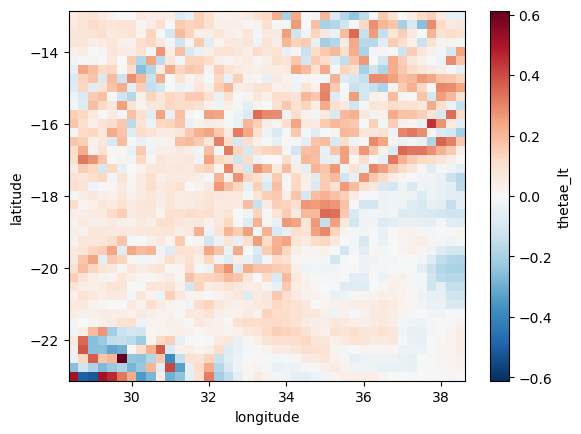

In [40]:
(BL_merged.thetae_lt-BL_merged_old.thetae_lt).plot()

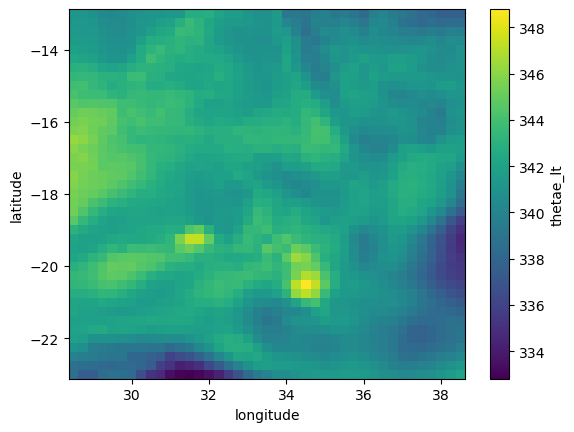

In [36]:
# check thetae_bl, thetae_lt, thetae_sat_lt
BL_merged.thetae_lt.plot()

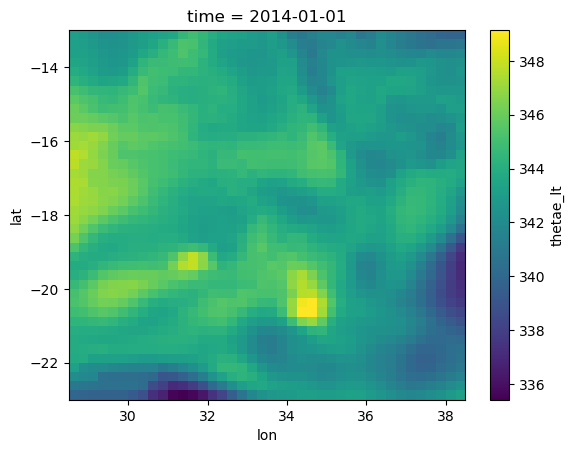

In [37]:
# check thetae_bl, thetae_lt, thetae_sat_lt
BUOY_sub.thetae_lt.plot()

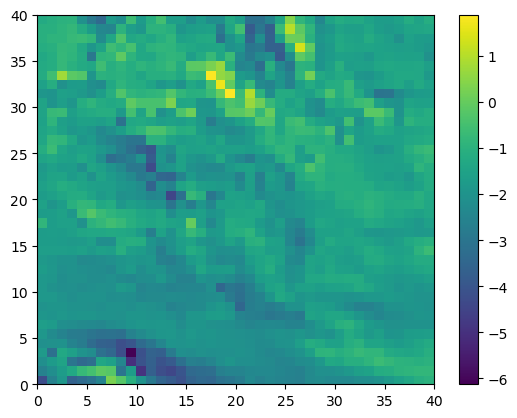

In [35]:
plt.pcolor(BL_merged.thetae_bl[:-1,:-1].values-BUOY_sub.thetae_bl.values)
plt.colorbar()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))
# thetae_BL
tmp = (BL_merged.thetae_bl.values[:-1,:-1]-thetae_bl.values)
cp1 = ax1.pcolormesh(thetae_bl.lon, thetae_bl.lat, tmp, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar(cp1, ax=ax1)
# thetae_LT
tmp = (BL_merged.thetae_lt.values[:-1,:-1]-thetae_lt.values)
cp2 = ax2.pcolormesh(thetae_lt.lon, thetae_lt.lat, tmp , vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar(cp2, ax=ax2)
# thetae_SAT_LT
tmp = (BL_merged.thetae_sat_lt.values[:-1,:-1]-thetae_sat_lt.values)
cp3 = ax3.pcolormesh(thetae_sat_lt.lon, thetae_sat_lt.lat, tmp, vmin=-2, vmax=2, cmap='RdBu')
plt.colorbar(cp3, ax=ax3)

In [ ]:
BL_merged.Buoy_TOT.mean()*340*3/9.81

In [ ]:
BL_TOT_ori.mean()*340*3/9.81

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection': ccrs.PlateCarree()})
    
ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

cf = ax.pcolormesh(BL_TOT_ori.lon, BL_TOT_ori.lat, BL_TOT_ori, vmin=-0.12,vmax=0.02, cmap='jet',
              transform=ccrs.PlateCarree())
plt.colorbar(cf,ax=ax,shrink=0.6)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}

### test playground

In [12]:
year = 2014
idt = 0 

In [20]:
sp = data_sp.isel(time=idt)
T2m = data_t2m.isel(time=idt)
q2m = data_q2m.isel(time=idt)
T = data_T.isel(time=idt)
q = data_q.isel(time=idt)

idx_lat = 0
idx_lon = 0

pbl_top_level = find_pbl_top_level(sp, T, pbl_depth=100)

sf_p = sp.isel(latitude=idx_lat, longitude=idx_lon) # surface pressure 
pbl_p = pbl_top_level.isel(latitude=idx_lat, longitude=idx_lon).pbl_top_level.values # pbl top pressure
T_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
q_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values

T_at_sf = T2m.isel(latitude=idx_lat, longitude=idx_lon).values
q_at_sf = q2m.isel(latitude=idx_lat, longitude=idx_lon).values
T_above_sf = T.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values
q_above_sf = q.isel(latitude=idx_lat, longitude=idx_lon).sel(level=slice(100,int(sf_p))).values

# reconstruct T, q profile by adding surface quantities
T_1d = np.concatenate([np.array([T_at_sf]), np.flip(T_above_sf)])            
q_1d = np.concatenate([np.array([q_at_sf]), np.flip(q_above_sf)])                
pressure_1d = np.concatenate([np.array([sf_p]), np.flip(T.sel(level=slice(100,int(sf_p))).level.values)])
T_1d_xr = xr.DataArray(data=T_1d,
                       dims=["level"],
                       coords=dict(level=(["level"], pressure_1d)))
q_1d_xr = xr.DataArray(data=q_1d,
                       dims=["level"],
                       coords=dict(level=(["level"], pressure_1d)))

pint_levels = pressure_1d

ind_pbl_top = np.argmin(abs(pint_levels - (int(sf_p)-100))) # index of pbl top
ind_pmid = np.argmin(abs(pint_levels - 500)) # index of 500 mb
pbl_thickness = pint_levels[0] - pint_levels[ind_pbl_top]
lt_thickness = pint_levels[ind_pbl_top] - pint_levels[ind_pmid]
thetae_bl = 0
thetae_lt = 0
thetae_sat_lt = 0

if (lt_thickness > 50): # larger than 50 mb

    for i in range(len(pint_levels)):
        
        if (i <= ind_pmid): # only integrated below mid level (500hPa)
        
            qs = qs_calc(T_1d_xr.isel(level=i)).values
            thetae = theta_e_calc(T_1d_xr.isel(level=i), q_1d_xr.isel(level=i)).values
            
            dp1 = pint_levels[i] - pint_levels[i+1]
            
            if (i < ind_pbl_top):
                
                if (i==0):
                    thetae_bl += thetae*dp1/2
                elif (i>0) & (i<ind_pbl_top):
                    dp2 = pint_levels[i-1]-pint_levels[i]
                    thetae_bl += thetae*(dp1+dp2)/2
                    
            else:
                thetae_sat = theta_e_calc(T_1d_xr.isel(level=i),qs).values
                
                if (i==ind_pbl_top):
                    
                    dp2 = pint_levels[i-1]-pint_levels[i]
                    thetae_bl += thetae*(dp2)/2
                    
                    thetae_lt += thetae*(dp1)/2
                    thetae_sat_lt += thetae_sat*(dp1)/2
                    
                elif (i>ind_pbl_top) & (i<ind_pmid):
                    
                    dp2 = pint_levels[i-1] - pint_levels[i]
                    thetae_lt += thetae*(dp1+dp2)/2
                    thetae_sat_lt += thetae_sat*(dp1+dp2)/2
                    
                elif (i==ind_pmid):
                    
                    dp2 = pint_levels[i-1]-pint_levels[i]
                    thetae_lt += thetae*(dp2)/2
                    thetae_sat_lt += thetae_sat*(dp2)/2
                    
    thetae_bl = thetae_bl/(pbl_thickness)
    thetae_lt = thetae_lt/(lt_thickness)
    thetae_sat_lt = thetae_sat_lt/(lt_thickness)
    
# splitting into boundary layer and lower free troposphere
# 1. boundary layer, bl
# q_bl = q_1d_xr.sel(level=slice(int(sf_p), pbl_p))
# T_bl = T_1d_xr.sel(level=slice(int(sf_p), pbl_p))
# # 2. lower free troposphere, lt
# q_lt = q_1d_xr.sel(level=slice(pbl_p,pbl_p-400))
# T_lt = T_1d_xr.sel(level=slice(pbl_p,pbl_p-400))     

# # calculating layer-averaged thetae components
# thetae_bl = -theta_e_calc(T_bl, q_bl).integrate('level')/(T_bl.level[0]-T_bl.level[-1]) # negative sign b.c. decreasing p
# thetae_lt = -theta_e_calc(T_lt, q_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1])
# qsat_lt = qs_calc(T_lt)
# thetae_sat_lt = -theta_e_calc(T_lt, qsat_lt).integrate('level')/(T_lt.level[0]-T_lt.level[-1]) 

329.8068617854048

In [ ]:
for i in range(10):
    print(theta_e_calc(T_1d_xr.isel(level=i), q_1d_xr.isel(level=i)).values)

In [ ]:
ind_pbl_top

In [ ]:
thetae_lt

In [ ]:
plt.plot(T_1d_xr, T_1d_xr.level)
plt.ylim([1000,100])